In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
print("GPU disponibile: ", tf.config.list_physical_devices('GPU'))

GPU disponibile:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Caricamento del dataset EMNIST

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML/datasets/emnist-letters.csv")
X = df.iloc[:,1:].to_numpy().reshape(-1, 28, 28, order="F")
y = df.iloc[:,0].to_numpy()-1

In [ ]:
X = X.reshape(-1,28,28,1)

# prendiamo il circa il 15% dei dati del dataset al fine di
# individuare training, validation e testing set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_valid, X_train = X_train_full[:11300] / 255., X_train_full[11300:] / 255.
y_valid, y_train = y_train_full[:11300], y_train_full[11300:]
X_test = X_test/255.


In [ ]:
X_train_full.shape

(75479, 28, 28, 1)

In [ ]:
y_train_full.shape

(75479,)

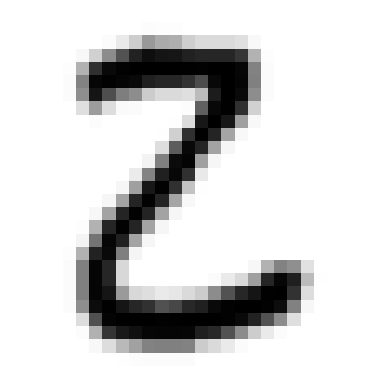

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
count = len(set(y_train))
print(count)

26


In [ ]:
class_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L","M",
               "N", "O", "P", "Q", "R", "S","T", "U", "V", "W", "X", "Y", "Z"]

display(X_valid.shape)

(11300, 28, 28, 1)

Modello basato su rete convoluzionale composta da:
  
  - 3 livelli convoluzionali;
  - 3 livelli pooling;
  - 3 livelli completamente connessi;

Usate tecniche di batch normalization, dropout, early stopping e con l'uso di Adam come algoritmo di ottimizzazione.

In [ ]:
ExamNet = tf.keras.models.Sequential([

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation='relu'),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3,activation='relu'),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(26, activation="softmax")])

ExamNet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

ExamNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_7 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 batch_normalization_8 (Bat  (None, 12, 12, 64)        256       
 chNormalization)                                                
                                                      

In [ ]:
historyExamNet = ExamNet.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
2422/2422 [==============================] - 17s 6ms/step - loss: 0.5601 - accuracy: 0.8263 - val_loss: 0.2373 - val_accuracy: 0.9199
Epoch 2/50
2422/2422 [==============================] - 13s 6ms/step - loss: 0.2975 - accuracy: 0.9055 - val_loss: 0.2235 - val_accuracy: 0.9246
Epoch 3/50
2422/2422 [==============================] - 14s 6ms/step - loss: 0.2540 - accuracy: 0.9186 - val_loss: 0.2052 - val_accuracy: 0.9310
Epoch 4/50
2422/2422 [==============================] - 16s 6ms/step - loss: 0.2301 - accuracy: 0.9249 - val_loss: 0.2017 - val_accuracy: 0.9342
Epoch 5/50
2422/2422 [==============================] - 14s 6ms/step - loss: 0.2099 - accuracy: 0.9302 - val_loss: 0.1793 - val_accuracy: 0.9415
Epoch 6/50
2422/2422 [==============================] - 14s 6ms/step - loss: 0.1977 - accuracy: 0.9346 - val_loss: 0.1953 - val_accuracy: 0.9367
Epoch 7/50
2422/2422 [==============================] - 14s 6ms/step - loss: 0.1812 - accuracy: 0.9386 - val_loss: 0.1813 - val_ac

In [ ]:
resultCNN = ExamNet.evaluate(X_test, y_test)

417/417 [==============================] - 4s 9ms/step - loss: 0.0801 - accuracy: 0.9691


In [ ]:
X_new = X_test[1:4]
y_proba = ExamNet.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 19ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.02,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ]], dtype=float32)

In [ ]:
y_pred = np.argmax(ExamNet.predict(X_new), axis=-1)
np.array(class_names)[y_pred]

1/1 [==============================] - 0s 18ms/step


array(['U', 'X', 'O'], dtype='<U1')

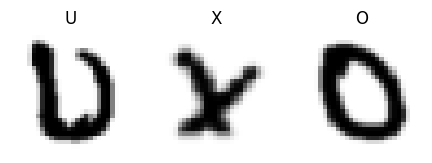

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 4, index+1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index+1]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

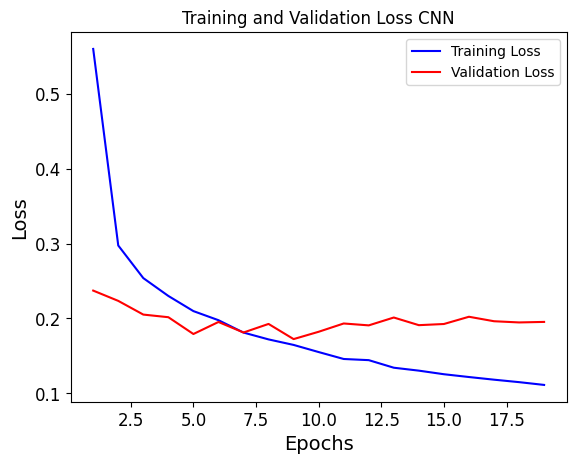

In [ ]:
# Estraggo i valori di loss per training e validation dallo storico
training_loss = historyExamNet.history['loss']
validation_loss = historyExamNet.history['val_loss']

# Creazione del grafico
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

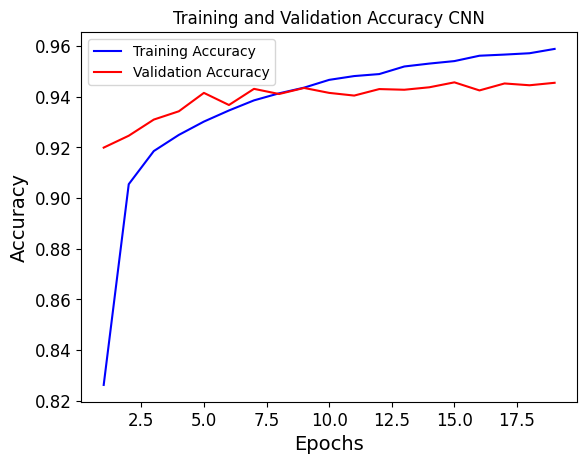

In [ ]:
# Estraggo i valori di accuracy per training e validation dallo storico
training_accuracy = historyExamNet.history['accuracy']
validation_accuracy = historyExamNet.history['val_accuracy']

# Creazione del grafico
epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Modello basato sulla precedente rete convoluzionale applicando la tecnica Dataset Augmentation

In [ ]:
X_train_aug = X_train
X_valid_aug = X_valid

In [ ]:
# Definisco oggetto ImageDataGenerator per effettuare l'augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
ExamNetAug = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation='relu'),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3,activation='relu'),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(26, activation="softmax")])


ExamNetAug.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

ExamNetAug.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_28 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 batch_normalization_29 (Ba  (None, 12, 12, 64)        256       
 tchNormalization)                                               
                                                      

In [ ]:
datagen.fit(X_train_aug)

historyExamNetAug = ExamNetAug.fit(datagen.flow(X_train_aug, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(X_valid_aug, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
2422/2422 [==============================] - 50s 20ms/step - loss: 1.4610 - accuracy: 0.5199 - val_loss: 0.7063 - val_accuracy: 0.7612
Epoch 2/50
2422/2422 [==============================] - 49s 20ms/step - loss: 0.9433 - accuracy: 0.6769 - val_loss: 0.6732 - val_accuracy: 0.7566
Epoch 3/50
2422/2422 [==============================] - 45s 19ms/step - loss: 0.8193 - accuracy: 0.7202 - val_loss: 0.6281 - val_accuracy: 0.7753
Epoch 4/50
2422/2422 [==============================] - 43s 18ms/step - loss: 0.7603 - accuracy: 0.7413 - val_loss: 0.5255 - val_accuracy: 0.8233
Epoch 5/50
2422/2422 [==============================] - 43s 18ms/step - loss: 0.7204 - accuracy: 0.7544 - val_loss: 0.5241 - val_accuracy: 0.8100
Epoch 6/50
2422/2422 [==============================] - 47s 19ms/step - loss: 0.6859 - accuracy: 0.7660 - val_loss: 0.5442 - val_accuracy: 0.8103
Epoch 7/50
2422/2422 [==============================] - 41s 17ms/step - loss: 0.6689 - accuracy: 0.7736 - val_loss: 0.4778 -

In [ ]:
ExamNetAug.evaluate(X_test, y_test)

417/417 [==============================] - 1s 3ms/step - loss: 0.3657 - accuracy: 0.8636


[0.36568567156791687, 0.8635885715484619]

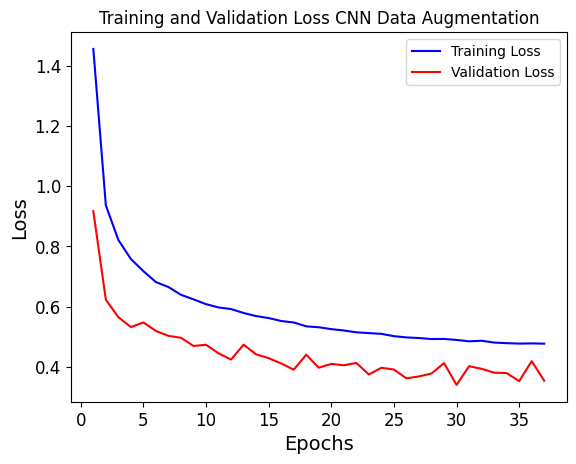

In [ ]:
training_loss = historyExamNetAug.history['loss']
validation_loss = historyExamNetAug.history['val_loss']

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss CNN Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

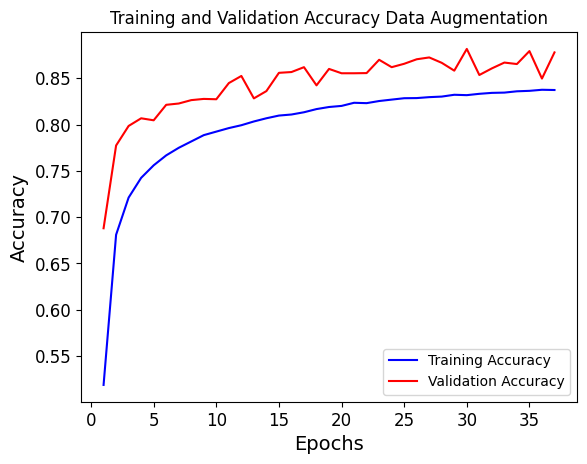

In [ ]:
# Estrai i valori di accuracy per training e validation dallo storico
training_accuracy = historyExamNetAug.history['accuracy']
validation_accuracy = historyExamNetAug.history['val_accuracy']

# Crea un grafico
epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Data Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Il modello si comporta male, questo può essere dovuto al fatto che la tecnica utilizzata per fare data augmentation ha introdotto delle distorsioni eccessive, causate da trasformazioni troppo intense o errate, che possono aver alterato in maniera importante le caratteristiche peculiari delle immagini originali, portando ad una maggiore difficoltà per la rete di apprendere modelli efficaci.

Modello basato sulla precedente rete convoluzionale applicando la tecnica Noise Injection

In [ ]:
# L'idea è di aggiungere rumore gaussiano alle immagini di addestramento
noise_factor = 0.3  # Regolando questo valore decido quanto rumore

x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)

In [ ]:
ExamNetNI = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation='relu'),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3,activation='relu'),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(26, activation="softmax")])


ExamNetNI.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

ExamNetNI.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_17 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 batch_normalization_18 (Ba  (None, 12, 12, 64)        256       
 tchNormalization)                                               
                                                      

In [ ]:
historyExamNetNI = ExamNetNI.fit(x_train_noisy, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
2422/2422 [==============================] - 16s 6ms/step - loss: 0.7298 - accuracy: 0.7768 - val_loss: 0.2791 - val_accuracy: 0.9074
Epoch 2/50
2422/2422 [==============================] - 14s 6ms/step - loss: 0.3749 - accuracy: 0.8820 - val_loss: 0.2528 - val_accuracy: 0.9177
Epoch 3/50
2422/2422 [==============================] - 13s 6ms/step - loss: 0.3087 - accuracy: 0.9008 - val_loss: 0.2156 - val_accuracy: 0.9291
Epoch 4/50
2422/2422 [==============================] - 14s 6ms/step - loss: 0.2842 - accuracy: 0.9081 - val_loss: 0.2139 - val_accuracy: 0.9313
Epoch 5/50
2422/2422 [==============================] - 15s 6ms/step - loss: 0.2562 - accuracy: 0.9174 - val_loss: 0.2133 - val_accuracy: 0.9301
Epoch 6/50
2422/2422 [==============================] - 14s 6ms/step - loss: 0.2389 - accuracy: 0.9215 - val_loss: 0.2235 - val_accuracy: 0.9320
Epoch 7/50
2422/2422 [==============================] - 13s 6ms/step - loss: 0.2175 - accuracy: 0.9260 - val_loss: 0.2144 - val_ac

In [ ]:
ExamNetNI.evaluate(X_test, y_test)

417/417 [==============================] - 1s 3ms/step - loss: 0.1467 - accuracy: 0.9541


[0.14668746292591095, 0.9541290998458862]

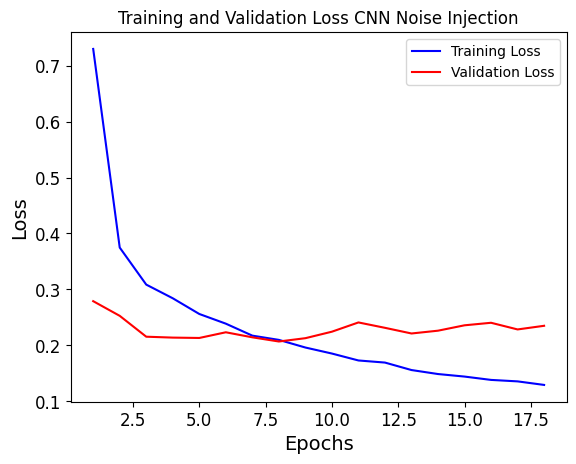

In [ ]:
training_loss = historyExamNetNI.history['loss']
validation_loss = historyExamNetNI.history['val_loss']


epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss CNN Noise Injection')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

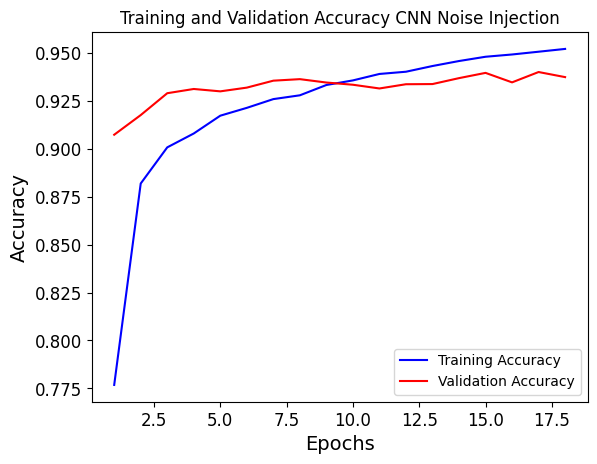

In [ ]:
# Estrai i valori di accuracy per training e validation dallo storico
training_accuracy = historyExamNetNI.history['accuracy']
validation_accuracy = historyExamNetNI.history['val_accuracy']

# Crea un grafico
epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy CNN Noise Injection')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Le prestazioni sono simili ma comunque inferiori alla rete iniziale, questo perchè probabilmente il modello è già sufficientemente complesso e in grado di catturare i pattern nei dati senza l'aggiunta di rumore, quindi l'iniezione di rumore risulta essere superflua o, in piccola parte, dannosa.

Modello basato su una rete neurale FeedForward con:
  
  - 1 livello di input;
  - 4 livelli nascosti;
  - 1 livello di output;

Con l'uso di batch normalization, early stopping ed Adam come algoritmo di ottimizzazione.

In [ ]:
FFExamNet = keras.models.Sequential()

FFExamNet.add(keras.layers.Flatten(input_shape=[28, 28]))
FFExamNet.add(keras.layers.Dense(300, activation="relu"))
FFExamNet.add(keras.layers.BatchNormalization())
FFExamNet.add(keras.layers.Dense(200, activation="relu"))
FFExamNet.add(keras.layers.BatchNormalization())

FFExamNet.add(keras.layers.Dense(100, activation="relu"))
FFExamNet.add(keras.layers.BatchNormalization())
FFExamNet.add(keras.layers.Dense(50, activation="relu"))
FFExamNet.add(keras.layers.BatchNormalization())
FFExamNet.add(keras.layers.Dense(26, activation="softmax"))

FFExamNet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

FFExamNet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 300)               235500    
                                                                 
 batch_normalization_10 (Ba  (None, 300)               1200      
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 200)               60200     
                                                                 
 batch_normalization_11 (Ba  (None, 200)               800       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 100)              

In [ ]:
historyFFExamNet = FFExamNet.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/50
2422/2422 [==============================] - 20s 7ms/step - loss: 0.8129 - accuracy: 0.7578 - val_loss: 0.4660 - val_accuracy: 0.8535
Epoch 2/50
2422/2422 [==============================] - 16s 7ms/step - loss: 0.4833 - accuracy: 0.8460 - val_loss: 0.3727 - val_accuracy: 0.8807
Epoch 3/50
2422/2422 [==============================] - 17s 7ms/step - loss: 0.4037 - accuracy: 0.8693 - val_loss: 0.3347 - val_accuracy: 0.8908
Epoch 4/50
2422/2422 [==============================] - 16s 7ms/step - loss: 0.3562 - accuracy: 0.8820 - val_loss: 0.3269 - val_accuracy: 0.8912
Epoch 5/50
2422/2422 [==============================] - 16s 7ms/step - loss: 0.3220 - accuracy: 0.8931 - val_loss: 0.3005 - val_accuracy: 0.8993
Epoch 6/50
2422/2422 [==============================] - 17s 7ms/step - loss: 0.2941 - accuracy: 0.9018 - val_loss: 0.3078 - val_accuracy: 0.9011
Epoch 7/50
2422/2422 [==============================] - 18s 8ms/step - loss: 0.2734 - accuracy: 0.9072 - val_loss: 0.2993 - val_ac

In [ ]:
resultFF = FFExamNet.evaluate(X_test, y_test)

417/417 [==============================] - 1s 3ms/step - loss: 0.1329 - accuracy: 0.9519


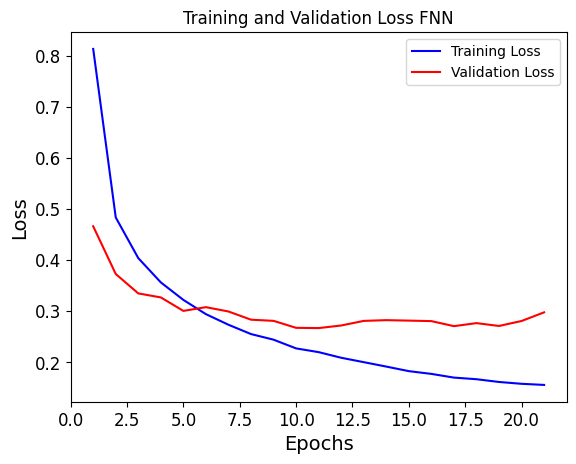

In [ ]:
training_loss = historyFFExamNet.history['loss']
validation_loss = historyFFExamNet.history['val_loss']

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss FNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

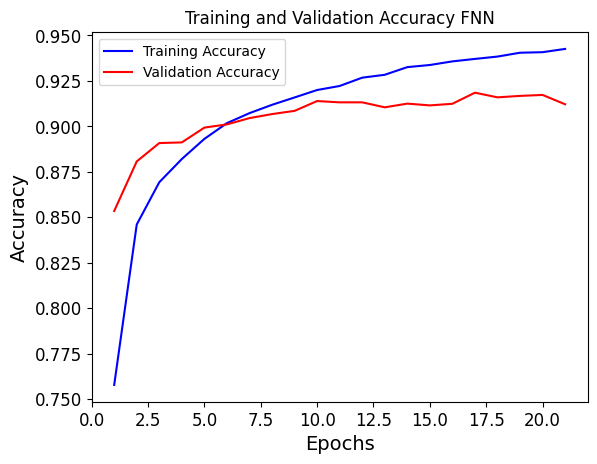

In [ ]:
training_accuracy = historyFFExamNet.history['accuracy']
validation_accuracy = historyFFExamNet.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy FNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Confronto accuratezza dei modelli CNN base vs. FNN sul validation set



19


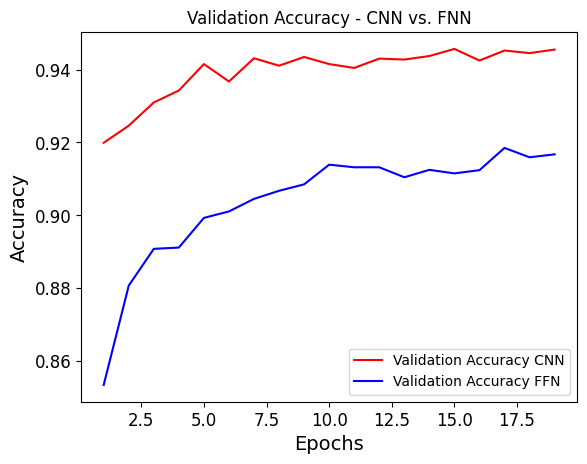

In [ ]:
validation_accuracyCNN = historyExamNet.history['val_accuracy']
validation_accuracyFNN = historyFFExamNet.history['val_accuracy']

epochs = range(1, min(len(validation_accuracyCNN), len(validation_accuracyFNN)) + 1)
print(min(len(validation_accuracyCNN), len(validation_accuracyFNN)))
plt.plot(epochs, validation_accuracyCNN[:min(len(validation_accuracyCNN), len(validation_accuracyFNN))], 'r', label='Validation Accuracy CNN')
plt.plot(epochs, validation_accuracyFNN[:min(len(validation_accuracyCNN), len(validation_accuracyFNN))], 'b', label='Validation Accuracy FFN')
plt.title('Validation Accuracy - CNN vs. FNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Modello basato Random Forest con l'uso di 25, 100 e 200 stimatori

In [ ]:
X_train_full_rf = X_train_full/255.
X_flat_train = X_train_full_rf.reshape((X_train_full_rf.shape[0], -1))
X_flat_test = X_test.reshape((X_test.shape[0], -1))

In [ ]:
#rf_classifier = RandomForestClassifier(n_estimators=25, random_state=42)
#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)

rf_classifier.fit(X_flat_train, y_train_full)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_flat_test)

# Valuta l'accuratezza del modello
accuracy = accuracy_score(y_test, y_pred)
loss = (y_test, y_pred)
print(accuracy)

0.876951951951952


Confronto tra i valori di accuracy riscontrati sul testing set rispettivamente sulla rete convoluzionale, sulla rete feedforward e con Random Forest.
Come ci si aspettava, la rete convoluzionale si comporta meglio.

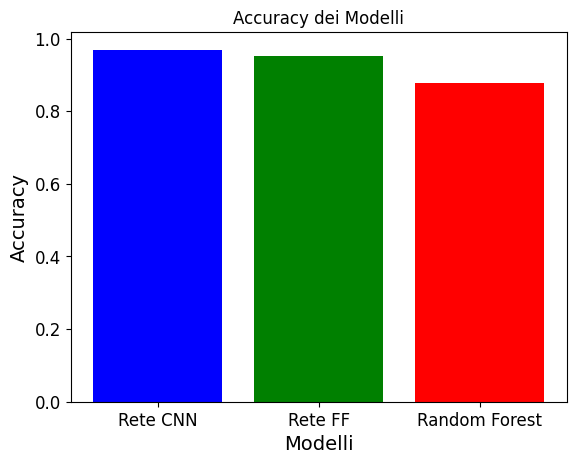

In [ ]:
accuracy_values = [resultCNN[1], resultFF[1], accuracy]
labels = ['Rete CNN', 'Rete FF', 'Random Forest']

plt.bar(labels, accuracy_values, color=['blue', 'green', 'red'])
plt.title('Accuracy dei Modelli')
plt.xlabel('Modelli')
plt.ylabel('Accuracy')
plt.show()